In [72]:
import pandas as pd
import numpy as np
import sklearn
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import datetime
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel as parallel
import torch.distributed as distributed
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from torchmetrics.classification import BinaryAccuracy
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, ParameterGrid
import skorch
from skorch import NeuralNetClassifier
from skorch import NeuralNetRegressor
from skorch.callbacks import EpochScoring
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from torch.nn import BCELoss
import torch.nn.init as init
import random
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import shap
# from dask_cuda import LocalCUDACluster
# from dask.distributed import Client
# from dask.distributed import Client, wait
# from dask_cuda import LocalCUDACluster
# from dask.utils import parse_bytes
# import cudf
# import dask_cudf
# from dask_ml.preprocessing import StandardScaler
# from dask_ml.impute import SimpleImputer
# from dask_ml.wrappers import ParallelPostFit
# from dask_ml.wrappers import Incremental
# from sklearn.svm import SVC
# import cuml
from torch.nn import init
import pickle
import dask
from dask import dataframe as dd
import dask.array as da
# import dask_ml.datasets
# import dask_ml.cluster
from dask.diagnostics import ProgressBar
ProgressBar().register()

In [73]:
#Set seeds to allow for reproducibility of the results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [74]:
data = pd.read_csv("intersect_4DNFI18UHVRO.10kb.with_id.with_transcripts.erna_gene_filt.with_exp.txt", sep = "\t")

In [75]:
#Prepare training, validation, and test data
train = data[["expression1", "expression2", "dist", "norm_contacts"]]
train_features = train.copy()

##Normalize the expression data so that the mean is 0
#mean_data = sum(train_features["expression1"]) / len(train_features["expression1"])
#train_features["expression1"] = [x - mean_data for x in train_features["expression1"]]

#mean_data = sum(train_features["expression2"]) / len(train_features["expression2"])
#train_features["expression2"] = [x - mean_data for x in train_features["expression2"]]

##Log-normalize contact frequencies
#train_features["norm_contacts"] = np.log(train_features["norm_contacts"])

##Log1p-normalize genomic distances
#train_features["dist"] = np.log1p(train_features["dist"])

train_labels = train_features.pop("norm_contacts")
#train_features.pop("dist")
train_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_prelim, train_labels_final, test_labels_prelim = train_test_split(train_features, train_labels, test_size=0.4, random_state=42)
val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [76]:
train_set_final = np.array(train_set_final)
train_set_final = torch.tensor(train_set_final, dtype=torch.float32)
train_set_final.shape

train_labels_final = np.array(train_labels_final)
train_labels_final = torch.tensor(train_labels_final, dtype=torch.float32)
train_labels_final.shape

torch.Size([51378])

In [77]:
val_set_final = np.array(val_set_final)
val_set_final = torch.tensor(val_set_final, dtype=torch.float32)
val_set_final.shape

val_labels_final = np.array(val_labels_final)
val_labels_final = torch.tensor(val_labels_final, dtype=torch.float32)
val_labels_final.shape

torch.Size([17126])

In [78]:
test_set_final = np.array(test_set_final)
test_set_final = torch.tensor(test_set_final, dtype=torch.float32)
test_set_final.shape

torch.Size([17126, 3])

In [79]:
train_features = np.array(train_features)
train_features = torch.tensor(train_features, dtype = torch.float32)

In [80]:
#Define the whole blood model and load in the weights
n_cols = 2
input_shape = n_cols

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self, input_size=input_shape, hidden_size=120, output_size=1, num_hidden_layers=2, weight_init_hidden=init.kaiming_uniform_, weight_init_out=init.kaiming_normal_):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        #self.activation = activation()
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = torch.nn.functional.hardsigmoid(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.nn.functional.hardsigmoid(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x

model = Net().to(device)
model.load_state_dict(torch.load('whole_blood_best_contact_regression_model.h5'))

<All keys matched successfully>

In [81]:
test_set_final[:,0:2]

tensor([[ 0.0301, -0.0984],
        [-0.0121, -0.0434],
        [ 0.2109,  0.0354],
        ...,
        [-0.0369, -0.0930],
        [-0.1186,  0.2387],
        [-0.1623,  0.4973]])

In [82]:
from sklearn.metrics import r2_score

# Evaluate performance on test set
y_pred = model(test_set_final[:,0:2].to("cuda:2"))

# Compute R-squared score
r2 = r2_score(test_labels_final, y_pred.detach().cpu().numpy())

print(r2)

0.21893281184985147


In [83]:
dist_contact_array = np.hstack((test_set_final[:,2].unsqueeze(1), y_pred.cpu().detach().numpy()))

In [84]:
dist_contact_array

array([[1.5314000e+08, 4.4799461e+00],
       [1.3509000e+08, 4.4799461e+00],
       [2.3200000e+06, 6.1030464e+00],
       ...,
       [2.6900000e+07, 4.4799461e+00],
       [6.0800000e+07, 3.3660536e+00],
       [7.3500000e+06, 3.3660536e+00]], dtype=float32)

In [85]:
correlation_matrix = np.corrcoef(dist_contact_array[:,0], dist_contact_array[:,1])
correlation = correlation_matrix[0, 1]
print(f"Pearson correlation between genomic distance and predicted contact frequency: {correlation:.2f}")

Pearson correlation between genomic distance and predicted contact frequency: -0.05


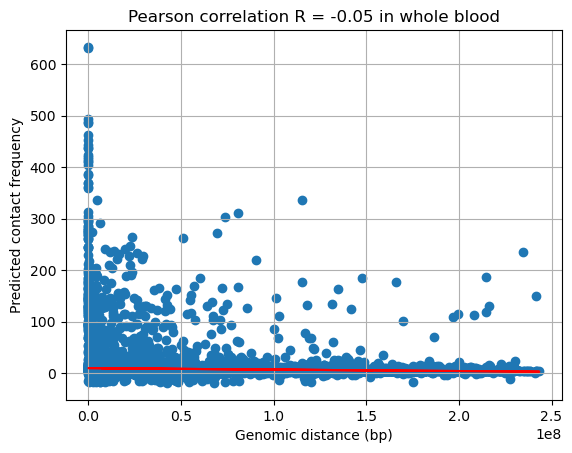

In [87]:
import matplotlib.pyplot as plt

m, b = np.polyfit(dist_contact_array[:,0], dist_contact_array[:,1], 1)  # Linear fit (1st degree polynomial)

plt.scatter(dist_contact_array[:,0], dist_contact_array[:,1])
plt.plot(dist_contact_array[:,0], m*dist_contact_array[:,0] + b, color='red', label=f'Trendline: y = {m:.2f}x + {b:.2f}')
plt.title(f"Pearson correlation R = {correlation:.2f} in whole blood")
plt.xlabel("Genomic distance (bp)")
plt.ylabel("Predicted contact frequency")
plt.grid(True)
#plt.show()
plt.savefig("whole_blood_dist_vs_pred_contact_freq.png", dpi=300)

In [88]:
dist_contact_array = np.hstack((test_set_final[:,2].unsqueeze(1), torch.tensor(test_labels_final).unsqueeze(1)))

In [89]:
torch.tensor(test_labels_final).unsqueeze(1).shape

torch.Size([17126, 1])

In [90]:
test_set_final[:,2].unsqueeze(1).shape

torch.Size([17126, 1])

In [91]:
correlation_matrix = np.corrcoef(dist_contact_array[:,0], dist_contact_array[:,1])
correlation = correlation_matrix[0, 1]
print(f"Pearson correlation between genomic distance and observed contact frequency: {correlation:.2f}")

Pearson correlation between genomic distance and observed contact frequency: -0.10


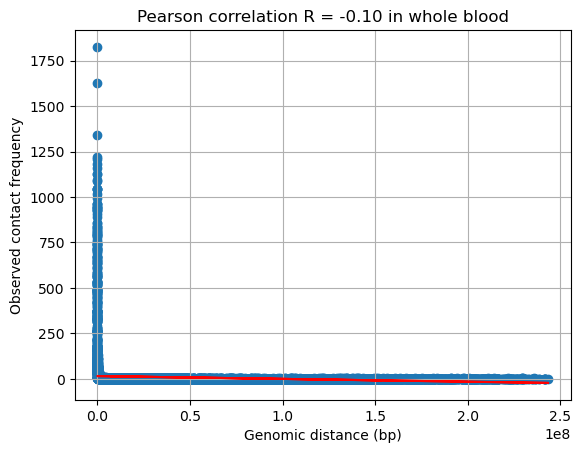

In [92]:
import matplotlib.pyplot as plt

m, b = np.polyfit(dist_contact_array[:,0], dist_contact_array[:,1], 1)  # Linear fit (1st degree polynomial)

plt.scatter(dist_contact_array[:,0], dist_contact_array[:,1])
plt.plot(dist_contact_array[:,0], m*dist_contact_array[:,0] + b, color='red', label=f'Trendline: y = {m:.2f}x + {b:.2f}')
plt.title(f"Pearson correlation R = {correlation:.2f} in whole blood")
plt.xlabel("Genomic distance (bp)")
plt.ylabel("Observed contact frequency")
plt.grid(True)
plt.show()

In [93]:
#Do the same for cerebellum
data = pd.read_csv("intersect_4DNFIWCAQUIK.10kb.with_id.with_transcripts.erna_gene_filt.with_exp.txt", sep = "\t")

In [94]:
#Prepare training, validation, and test data
train = data[["expression1", "expression2", "dist", "norm_contacts"]]
train_features = train.copy()

##Normalize the expression data so that the mean is 0
#mean_data = sum(train_features["expression1"]) / len(train_features["expression1"])
#train_features["expression1"] = [x - mean_data for x in train_features["expression1"]]

#mean_data = sum(train_features["expression2"]) / len(train_features["expression2"])
#train_features["expression2"] = [x - mean_data for x in train_features["expression2"]]

##Log-normalize contact frequencies
#train_features["norm_contacts"] = np.log(train_features["norm_contacts"])

##Log1p-normalize genomic distances
#train_features["dist"] = np.log1p(train_features["dist"])

train_labels = train_features.pop("norm_contacts")
#train_features.pop("dist")
train_labels

#train_labels = list(map(lambda x: x.replace('ad', '0'), train_labels))
#train_labels = list(map(lambda x: x.replace('scc', '1'), train_labels))

#train_labels = [int(x) for x in train_labels]
train_labels = np.array(train_labels)

train_labels

train_set_final, test_set_prelim, train_labels_final, test_labels_prelim = train_test_split(train_features, train_labels, test_size=0.4, random_state=42)
val_set_final, test_set_final, val_labels_final, test_labels_final = train_test_split(test_set_prelim, test_labels_prelim, test_size=0.5, random_state=42)

In [95]:
train_set_final = np.array(train_set_final)
train_set_final = torch.tensor(train_set_final, dtype=torch.float32)
train_set_final.shape

train_labels_final = np.array(train_labels_final)
train_labels_final = torch.tensor(train_labels_final, dtype=torch.float32)
train_labels_final.shape

torch.Size([57420])

In [96]:
val_set_final = np.array(val_set_final)
val_set_final = torch.tensor(val_set_final, dtype=torch.float32)
val_set_final.shape

val_labels_final = np.array(val_labels_final)
val_labels_final = torch.tensor(val_labels_final, dtype=torch.float32)
val_labels_final.shape

torch.Size([19140])

In [97]:
test_set_final = np.array(test_set_final)
test_set_final = torch.tensor(test_set_final, dtype=torch.float32)
test_set_final.shape

torch.Size([19141, 3])

In [98]:
train_features = np.array(train_features)
train_features = torch.tensor(train_features, dtype = torch.float32)

In [99]:
#Define the cerebellum model and load in the weights
n_cols = 2
input_shape = n_cols

device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

class Net(nn.Module):
    def __init__(self, input_size=2, hidden_size=90, output_size=1, num_hidden_layers=2, weight_init_hidden=init.xavier_normal_, weight_init_out=init.xavier_uniform_):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.num_hidden_layers = num_hidden_layers - 1
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for i in range(num_hidden_layers - 1)])
        self.fc2 = nn.Linear(hidden_size, output_size)
        #self.activation = activation()
        # manually init weights
        weight_init_hidden(self.fc1.weight)
        for i, hidden_layer in enumerate(self.hidden_layers):
            weight_init_hidden(hidden_layer.weight)
        weight_init_out(self.fc2.weight)

    def forward(self, x):
        x = torch.nn.functional.softsign(self.fc1(x))
        for i in range(self.num_hidden_layers):
            x = torch.nn.functional.softsign(self.hidden_layers[i](x))
        x = self.fc2(x)
        return x

model = Net().to(device)
model.load_state_dict(torch.load('cerebellum_best_contact_regression_model.h5'))

<All keys matched successfully>

In [100]:
test_set_final[:,0:2]

tensor([[-0.5709,  0.1458],
        [-0.1768, -0.0626],
        [-0.0243, -0.1296],
        ...,
        [-0.0307,  0.2361],
        [-0.1718,  0.6626],
        [-0.0120,  0.3763]])

In [101]:
from sklearn.metrics import r2_score

# Evaluate performance on test set
y_pred = model(test_set_final[:,0:2].to("cuda:2"))

# Compute R-squared score
r2 = r2_score(test_labels_final, y_pred.detach().cpu().numpy())

print(r2)

0.37759778657811827


In [102]:
dist_contact_array = np.hstack((test_set_final[:,2].unsqueeze(1), y_pred.cpu().detach().numpy()))

In [103]:
dist_contact_array

array([[1.9170000e+07, 3.2165127e+00],
       [3.1160000e+07, 3.2663505e+00],
       [1.7100000e+06, 1.6501317e+00],
       ...,
       [4.6060000e+07, 2.9803131e+00],
       [3.2510000e+07, 2.2800896e+00],
       [1.3640000e+07, 1.6360211e+00]], dtype=float32)

In [104]:
correlation_matrix = np.corrcoef(dist_contact_array[:,0], dist_contact_array[:,1])
correlation = correlation_matrix[0, 1]
print(f"Pearson correlation between genomic distance and predicted contact frequency: {correlation:.2f}")

Pearson correlation between genomic distance and predicted contact frequency: -0.08


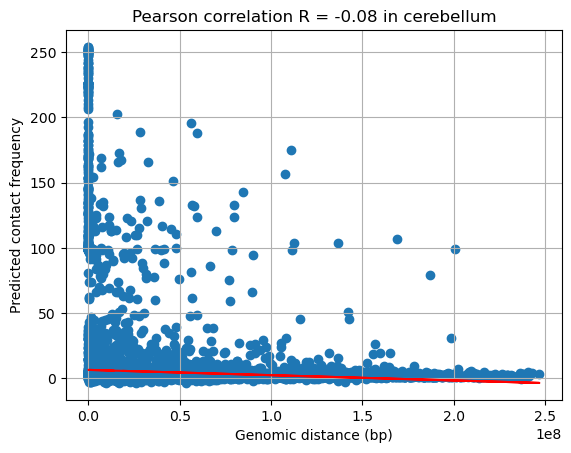

In [105]:
import matplotlib.pyplot as plt

m, b = np.polyfit(dist_contact_array[:,0], dist_contact_array[:,1], 1)  # Linear fit (1st degree polynomial)

plt.scatter(dist_contact_array[:,0], dist_contact_array[:,1])
plt.plot(dist_contact_array[:,0], m*dist_contact_array[:,0] + b, color='red', label=f'Trendline: y = {m:.2f}x + {b:.2f}')
plt.title(f"Pearson correlation R = {correlation:.2f} in cerebellum")
plt.xlabel("Genomic distance (bp)")
plt.ylabel("Predicted contact frequency")
plt.grid(True)
#plt.show()
plt.savefig("cerebellum_dist_vs_pred_contact_freq.png", dpi=300)

In [106]:
dist_contact_array = np.hstack((test_set_final[:,2].unsqueeze(1), torch.tensor(test_labels_final).unsqueeze(1)))

In [107]:
torch.tensor(test_labels_final).unsqueeze(1).shape

torch.Size([19141, 1])

In [108]:
test_set_final[:,2].unsqueeze(1).shape

torch.Size([19141, 1])

In [109]:
correlation_matrix = np.corrcoef(dist_contact_array[:,0], dist_contact_array[:,1])
correlation = correlation_matrix[0, 1]
print(f"Pearson correlation between genomic distance and observed contact frequency: {correlation:.2f}")

Pearson correlation between genomic distance and observed contact frequency: -0.11


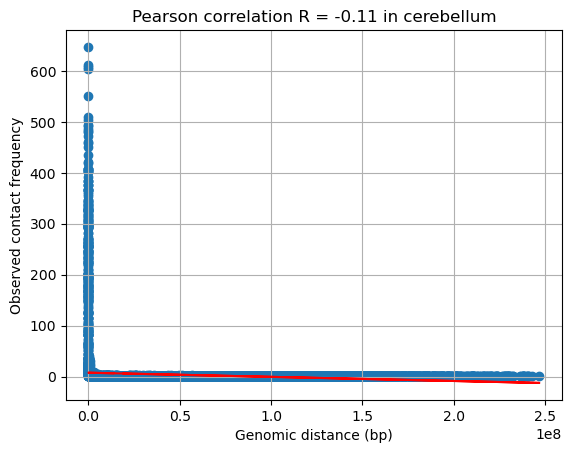

In [110]:
import matplotlib.pyplot as plt

m, b = np.polyfit(dist_contact_array[:,0], dist_contact_array[:,1], 1)  # Linear fit (1st degree polynomial)

plt.scatter(dist_contact_array[:,0], dist_contact_array[:,1])
plt.plot(dist_contact_array[:,0], m*dist_contact_array[:,0] + b, color='red', label=f'Trendline: y = {m:.2f}x + {b:.2f}')
plt.title(f"Pearson correlation R = {correlation:.2f} in cerebellum")
plt.xlabel("Genomic distance (bp)")
plt.ylabel("Observed contact frequency")
plt.grid(True)
plt.show()